In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import warnings
import seaborn as sns
import matplotlib.dates as mdates
warnings.filterwarnings('ignore')

plt.style.use("dark_background")


# Import data

* https://fred.stlouisfed.org

In [2]:
from fredapi import Fred
key=''

fred = Fred(api_key=key)

data={}
codes={'Inflation': 'CPIAUCSL','WTI': 'WTISPLC','Unemployment':'UNRATE','Financial Condition': 'NFCI','Capacity':'MCUMFN','Infl Expectations': 'EXPINF1YR','Retail Confidence':'CSCICP03USM665S','Manufacturing confidence':'BSCICP03USM665S'}

for i in codes.values():
    data[i]=fred.get_series(i)

In [6]:
df=pd.DataFrame.from_dict(data).ffill().resample('MS').ffill().dropna()
df.columns=codes.keys()
df[['Inflation','WTI','Unemployment','Capacity']]=df[['Inflation','WTI','Unemployment','Capacity']].pct_change(12)*100
df.dropna(inplace=True)
display(df)

,Inflation,WTI,Unemployment,Financial Condition,Capacity,Infl Expectations,Retail Confidence,Manufacturing confidence
1983-01-01,3.707627,-7.858198,20.930233,0.55152,-1.939678,4.863305,98.274838,98.611176
1983-02-01,3.484688,-8.269962,16.853933,0.20939,-4.530065,4.595662,98.700871,99.555334
1983-03-01,3.590285,1.193820,14.444444,0.02356,-2.699464,4.062945,99.393625,100.075545
1983-04-01,4.000000,-8.490284,9.677419,-0.00554,-0.638772,4.628920,100.137498,100.385036
1983-05-01,3.441084,-16.504314,7.446809,-0.11553,0.990123,4.618633,100.633682,100.750241
...,...,...,...,...,...,...,...,...
2022-05-01,8.516413,68.098818,-37.931034,-0.33018,3.307433,3.634658,96.369892,100.387736
2022-06-01,8.995221,60.885402,-38.983051,-0.24247,2.623263,4.226713,95.940128,100.108881
2022-07-01,8.482130,40.184853,-35.185185,-0.14042,2.002722,3.309278,95.900477,99.924482
2022-08-01,8.249235,38.299129,-28.846154,-0.18866,2.329436,3.377132,96.177060,99.809795


In [7]:
forecast_windows=3
df['Ahead Inflation']=df['Inflation'].shift(-forecast_windows)
df

,Inflation,WTI,Unemployment,Financial Condition,Capacity,Infl Expectations,Retail Confidence,Manufacturing confidence,Ahead Inflation
1983-01-01,3.707627,-7.858198,20.930233,0.55152,-1.939678,4.863305,98.274838,98.611176,4.000000
1983-02-01,3.484688,-8.269962,16.853933,0.20939,-4.530065,4.595662,98.700871,99.555334,3.441084
1983-03-01,3.590285,1.193820,14.444444,0.02356,-2.699464,4.062945,99.393625,100.075545,2.474227
1983-04-01,4.000000,-8.490284,9.677419,-0.00554,-0.638772,4.628920,100.137498,100.385036,2.358974
1983-05-01,3.441084,-16.504314,7.446809,-0.11553,0.990123,4.618633,100.633682,100.750241,2.456499
...,...,...,...,...,...,...,...,...,...
2022-05-01,8.516413,68.098818,-37.931034,-0.33018,3.307433,3.634658,96.369892,100.387736,8.249235
2022-06-01,8.995221,60.885402,-38.983051,-0.24247,2.623263,4.226713,95.940128,100.108881,7.806312
2022-07-01,8.482130,40.184853,-35.185185,-0.14042,2.002722,3.309278,95.900477,99.924482,NaN
2022-08-01,8.249235,38.299129,-28.846154,-0.18866,2.329436,3.377132,96.177060,99.809795,NaN


#  Data manipulation

In [8]:
split_date='2006-01-01'
df_train=df[df.index < split_date]
df_test=df[df.index > split_date]
split_date=df_train.index[-1]
split_date

Timestamp('2005-12-01 00:00:00', freq='MS')

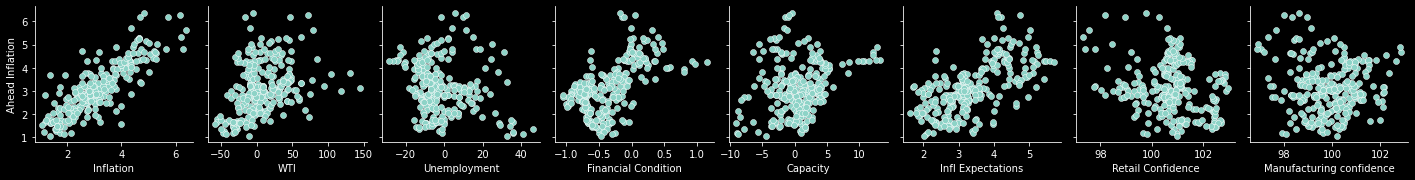

In [9]:
sns.pairplot(data=df_train,x_vars=df.columns[:-1],y_vars=df.columns[-1])

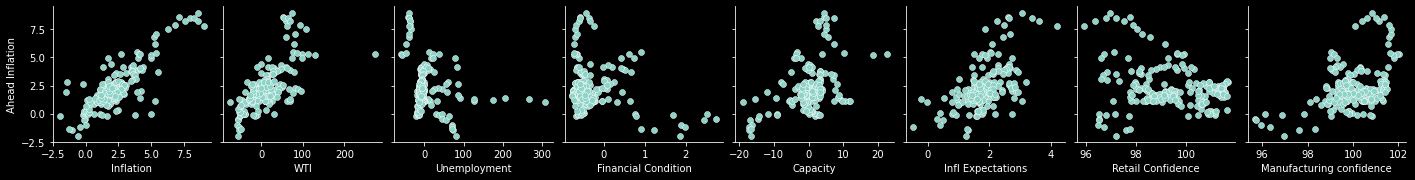

In [10]:
sns.pairplot(data=df_test,x_vars=df.columns[:-1],y_vars=df.columns[-1])

# XGBoost
## Training

In [11]:
from xgboost import  XGBRegressor

In [12]:
import itertools
parameters={'random_state': [100],'lambda':[1,2,3],'max_depth': [4,5,6],'n_estimators': [50,100,200],'eta':[0.1,0.2,0.3]}
parameters_=list((dict(zip(parameters, x)) for x in itertools.product(*parameters.values())))

In [13]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import explained_variance_score

from sklearn.metrics import r2_score

acc=[]
accuracy=[]
for param in parameters_:
    tscv = TimeSeriesSplit(n_splits=10)
    model = XGBRegressor(**param)
    for train_index, test_index in tscv.split(df_train):
        X_train, X_test = df_train.iloc[train_index,:-1], df_train.iloc[test_index,:-1]
        y_train, y_test = df_train.iloc[train_index,-1], df_train.iloc[test_index,-1]
        model.fit(X_train, y_train)
        
        y_pr = model.predict(X_test)

        # scoring
        acc.append(r2_score(y_test,y_pr))
    accuracy.append(np.mean(acc))

best_param = parameters_[np.argmax(accuracy)]
best_param

{'random_state': 100,
 'lambda': 3,
 'max_depth': 6,
 'n_estimators': 50,
 'eta': 0.2}

In [14]:
def deploy(X,y,title='',roll=12):
    predicted=[]
    imp=[]
    for i in range(roll+forecast_windows,len(X)):
        model = XGBRegressor(**best_param)

        X_fit = X.iloc[i-roll-forecast_windows:i-forecast_windows]
        y_fit = y.iloc[i-roll-forecast_windows:i-forecast_windows]

        model = model.fit(X_fit, y_fit)
        imp.append(model.feature_importances_)
        X_predict = X.iloc[i:i+ 1]
        y_pred = model.predict(X_predict)
        predicted.append(y_pred)

    predicted_df=pd.DataFrame(predicted,index=X.iloc[forecast_windows+roll:].index)
    plt.plot(predicted_df,label='XGBoost inflation prediction ('+ str(forecast_windows)+' months before)',color='red')
    plt.plot(X['Infl Expectations'].shift(12).iloc[roll+forecast_windows:],label='Expectations (12 months before)')
    plt.plot(X['Inflation'].iloc[roll+forecast_windows:],label='CPI YoY',color='green')
    plt.legend()
    plt.title(title)
    plt.show()

    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)  
    pd.DataFrame(imp,columns=X.columns,index=X.index[roll+forecast_windows:]).plot.bar(stacked=True,figsize=(15,5),ax=ax)
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=6))
    plt.title('Features importance')
    plt.show()
    return predicted_df

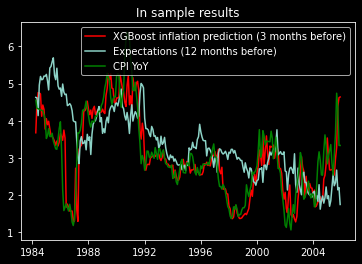

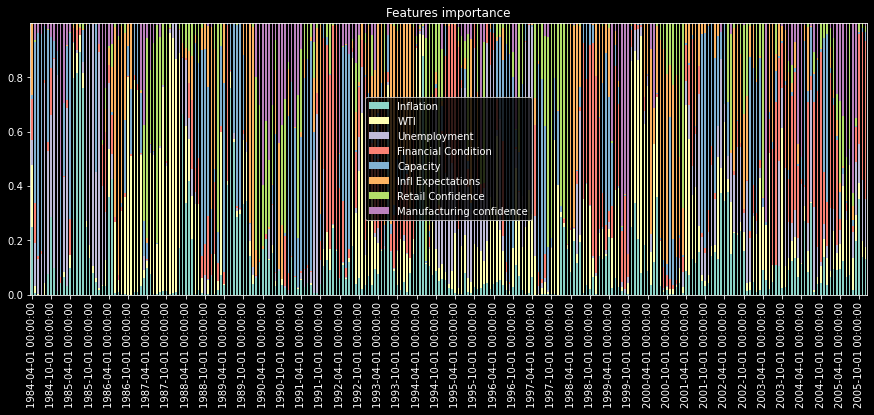

In [14]:
X,y=df_train.iloc[:,:-1],df_train.iloc[:,-1] 

train_df=deploy(df_train.iloc[:,:-1],df_train.iloc[:,-1],'In sample results')

## Out of sample

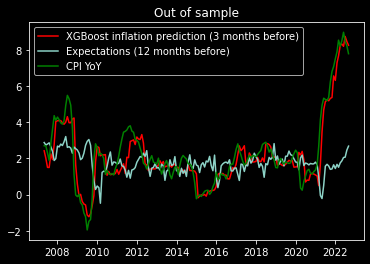

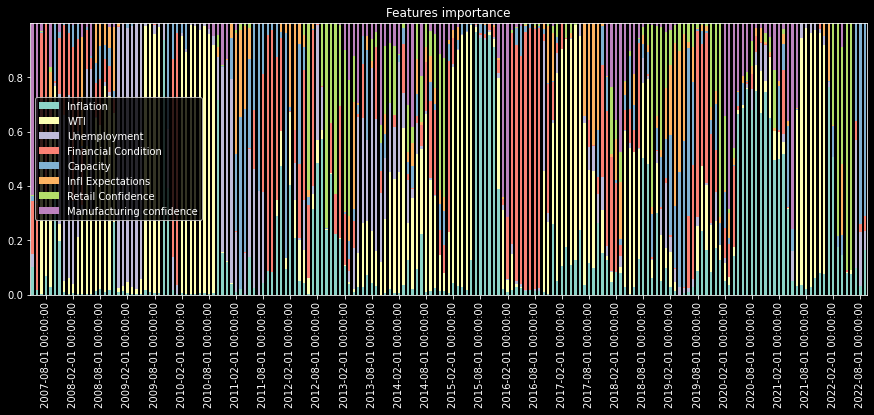

In [15]:
predicted_df= deploy(df_test.iloc[:,:-1],df_test.iloc[:,-1], 'Out of sample')

In [20]:
predicted_df.shift(1).to_csv('inflation.csv')

In [ ]:
y_actual=df.loc[df_test.index]['Inflation'].iloc[roll+forecast_windows:].ffill()

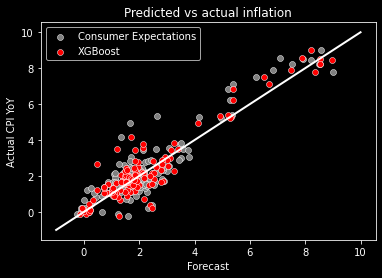

In [ ]:
sns.scatterplot(x=df_test['Inflation'],y=df_test['Ahead Inflation'],label='Consumer Expectations',color='gray')
sns.scatterplot(x=predicted_df.iloc[:,0],y=y_actual,label='XGBoost',color='red')
plt.plot([-1, 10], [-1, 10], linewidth=2,color='white')
plt.xlabel('Forecast')
plt.ylabel('Actual CPI YoY')

plt.title('Predicted vs actual inflation')
plt.show()

In [ ]:
print('Explained Variance: ', "{:.2%}".format(explained_variance_score(y_actual,predicted_df)))

print('R2: ', "{:.2%}".format(r2_score(y_actual,predicted_df)))

from sklearn.metrics import mean_absolute_error
print('Mean Abs Error: ', "{:.2%}".format(mean_absolute_error(y_actual,predicted_df)/100))

from sklearn.metrics import mean_squared_error
print('RMSE: ', "{:.2%}".format(mean_squared_error(y_actual,predicted_df,squared=False)/100))

from sklearn.metrics import max_error
print('Max Error: ', "{:.2%}".format(max_error(y_actual,predicted_df)/100))



Explained Variance:  88.68%
R2:  88.34%
Mean Abs Error:  0.48%
RMSE:  0.69%
Max Error:  2.45%


In [ ]:
model = XGBRegressor(**best_param)

X_fit = df.iloc[-forecast_windows-roll:-forecast_windows,:-1]
y_fit = df.iloc[-forecast_windows-roll:-forecast_windows,-1].ffill()

model = model.fit(X_fit, y_fit)

y_pred = model.predict(np.array(df.iloc[-6:,:-1]))

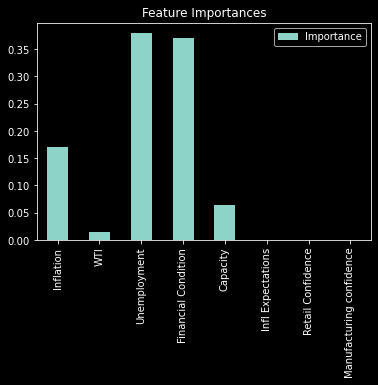

In [ ]:
pd.DataFrame(model.feature_importances_,X.columns,['Importance']).plot.bar()
plt.title('Feature Importances')
plt.show()

In [ ]:
print('Expected inflation in march 2023: ', "{:.2%}".format(y_pred[-1]/100))

Expected inflation in march 2023:  8.32%


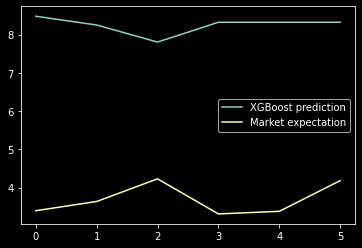

In [ ]:
pd.DataFrame(y_pred,columns=['XGBoost prediction']).plot()
plt.plot(df['Infl Expectations'].iloc[-6:].reset_index().drop('index',axis=1),label='Market expectation')
plt.legend()
plt.show()

[*********************100%***********************]  1 of 1 completed


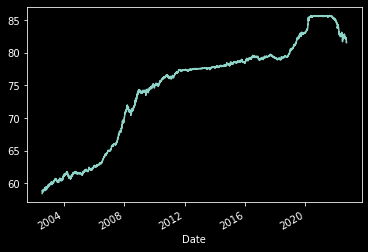

In [ ]:
import yfinance as yf

shy=yf.download('SHY')['Adj Close']
shy.plot()
plt.show()

In [ ]:
expected=fred.get_series('EXPINF1YR')

In [ ]:
expected

1982-01-01         NaN
1982-02-01         NaN
1982-03-01         NaN
1982-04-01         NaN
1982-05-01         NaN
                ...   
2022-05-01    2.705550
2022-06-01    2.881980
2022-07-01    2.944495
2022-08-01    3.096771
2022-09-01    3.266744
Length: 489, dtype: float64

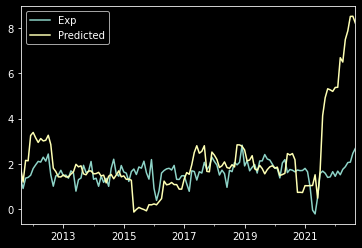

In [ ]:
j=pd.concat([expected.shift(12),predicted_df.shift(3)],axis=1).dropna()
j.columns=['Exp','Predicted']
j.plot()
plt.show()

<AxesSubplot:>

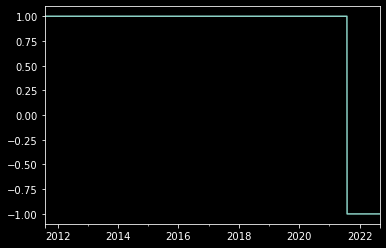

In [ ]:
weights=(j['Exp']+2>j['Predicted']).resample('D').ffill().astype(int)
weights[weights==0]=-1
weights.plot()

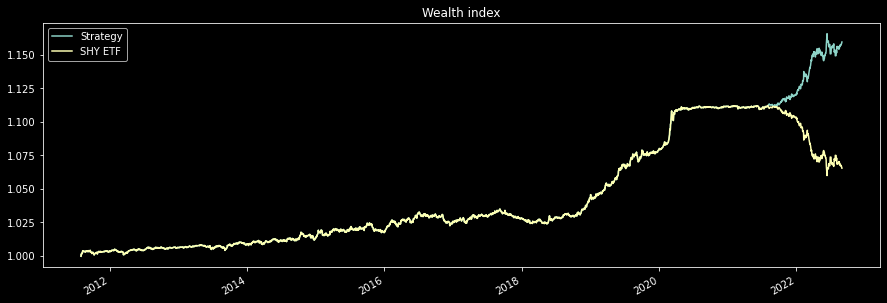

In [ ]:
ptf=((shy.pct_change()*weights)+1).cumprod().dropna()
plt.title('Wealth index')
ptf.plot(figsize=(15,5),label='Strategy')
(shy.pct_change().loc[ptf.index]+1).cumprod().plot(label='SHY ETF')
plt.legend()
plt.show()

In [ ]:
(ptf[-1]/ptf[0])**(12/len(j))-1

0.01336862624805324

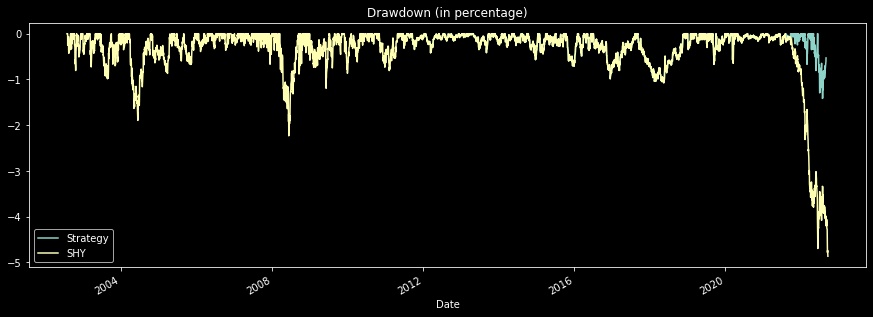

In [ ]:
((ptf-ptf.expanding().max())/ptf.expanding().max()*100).plot(title='Drawdown (in percentage)',figsize=(15,5),label='Strategy')
((shy-shy.expanding().max())/shy.expanding().max()*100).plot(label='SHY')
plt.legend()